In [1]:
import sys
sys.path.append('../..')
from torchuq.metric.distribution import *
import numpy as np
import torch
from matplotlib import pyplot as plt

In [11]:
# Unit test for the compute_crps, compare CRPS computed by our code and another library
# There should be a tiny difference because of different numerical integration algorithms
import properscoring as ps

n_sample = 100

means_np = np.linspace(0, 4, n_sample)
predictions = torch.distributions.normal.Normal(loc=torch.linspace(0, 4, n_sample), scale=torch.ones(n_sample))
wrong_dist = torch.distributions.normal.Normal(loc=torch.linspace(0, 4, n_sample), scale=torch.ones(n_sample) * 0.1)
samples = predictions.sample()

# Check that the CRPS score is the same 
ours = compute_crps(predictions, torch.ones(n_sample), resolution=1000)
alt = ps.crps_gaussian(np.ones(n_sample), mu=means_np, sig=np.ones(n_sample)).mean()
assert (ours - alt).abs() < 1e-3

ours = compute_crps(predictions, samples, resolution=1000)
alt = ps.crps_gaussian(samples, mu=means_np, sig=np.ones(n_sample)).mean()
assert (ours - alt).abs() < 1e-3

ours = compute_crps(wrong_dist, samples, resolution=1000)
alt = ps.crps_gaussian(samples, mu=means_np, sig=np.ones(n_sample) * 0.1).mean()
assert (ours - alt).abs() < 1e-3

# Check that the output shape is correct
print(compute_crps(predictions, samples, reduction='mean').shape)
print(compute_crps(predictions, samples, reduction='sum').shape)
print(compute_crps(predictions, samples, reduction='none').shape)
assert compute_crps(predictions, samples, reduction='none').mean() == compute_crps(predictions, samples, reduction='mean')

torch.Size([])
torch.Size([])
torch.Size([100])


In [13]:
# Unit test for compute_std and compute_mean
predictions = torch.distributions.normal.Normal(loc=torch.linspace(0, 4, n_sample), scale=torch.linspace(1, 4, n_sample))

residue = compute_std(predictions, resolution=5000, reduction='none') - torch.linspace(1, 4, n_sample)
assert residue.abs().max() < 1e-3   

residue = compute_mean(predictions, resolution=5000, reduction='none') - torch.linspace(0, 4, n_sample)
assert residue.abs().max() < 1e-3

tensor(0.0158)


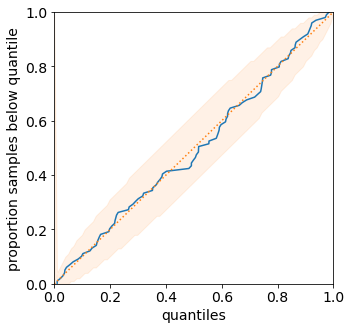

In [14]:
# Test plot_reliability_diagram
predictions = torch.distributions.normal.Normal(loc=torch.linspace(0, 4, n_sample), scale=torch.ones(n_sample))
samples = predictions.sample()
plot_reliability_diagram(predictions, samples)
print(compute_ece(predictions, samples))
plt.show()

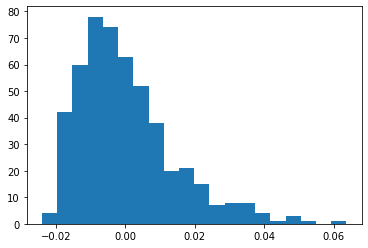

In [15]:
# Test compute_ece 
eces = []
for i in range(500):
    samples = predictions.sample()
    eces.append(compute_ece(predictions, samples, debiased=True).cpu().item())
plt.hist(eces, bins=20)   # This should be centered around 0
plt.show()
assert np.mean(eces) < 1e-3   # This should have no bias

<AxesSubplot:xlabel='sample index', ylabel='label value'>

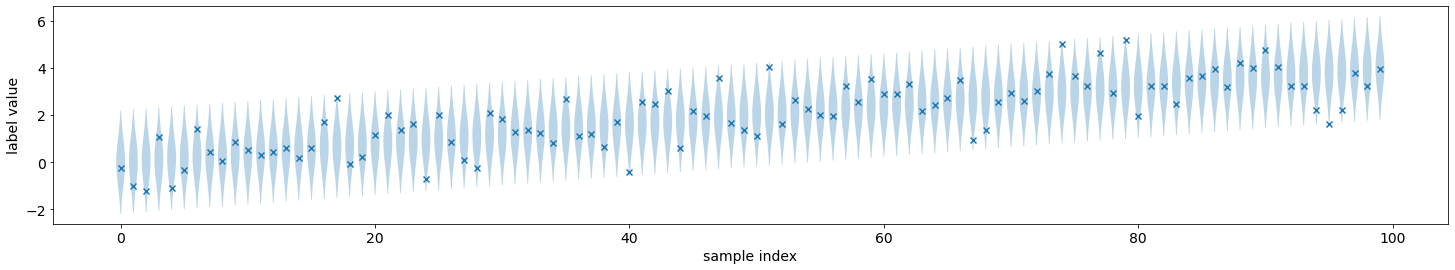

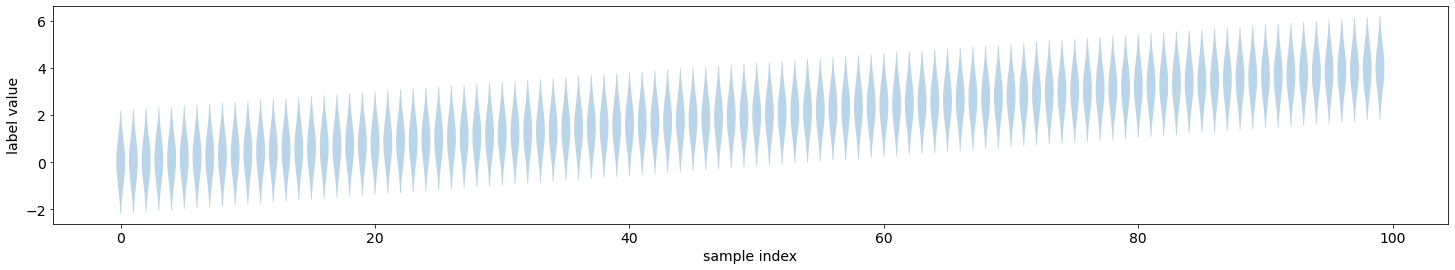

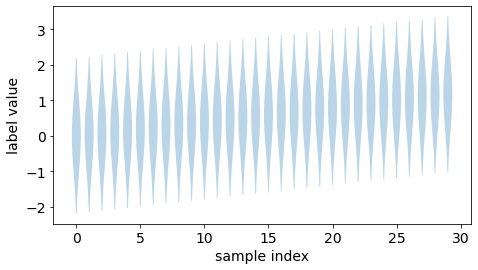

In [16]:
plot_density(predictions, samples)
plot_density(predictions)
plot_density(predictions, max_count=30)

<AxesSubplot:xlabel='sample index', ylabel='CDF'>

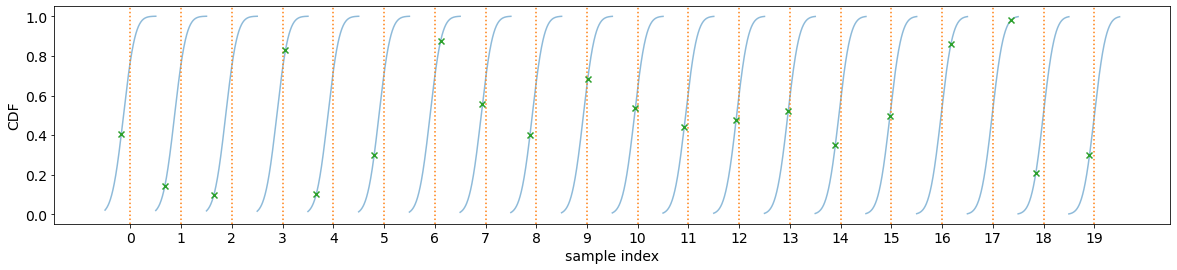

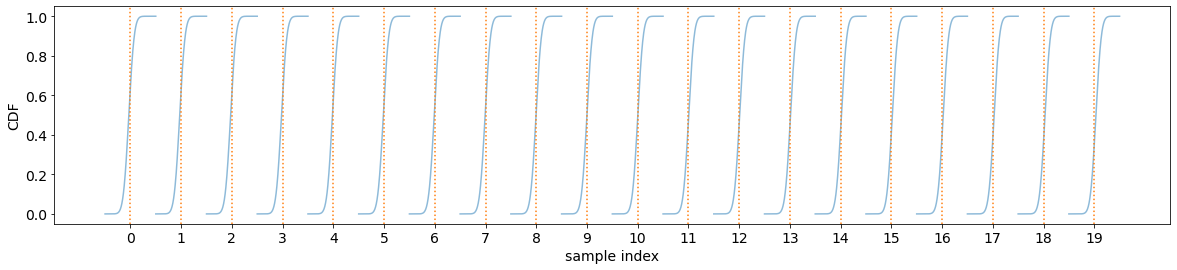

In [17]:
plot_cdf_sequence(predictions, samples)
plot_cdf_sequence(predictions)

<AxesSubplot:xlabel='value', ylabel='cdf'>

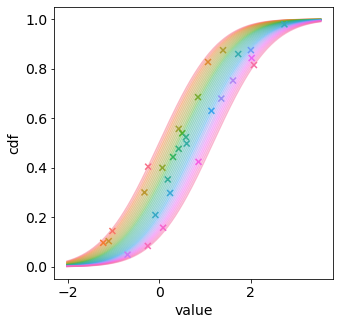

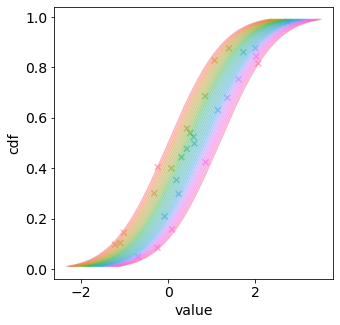

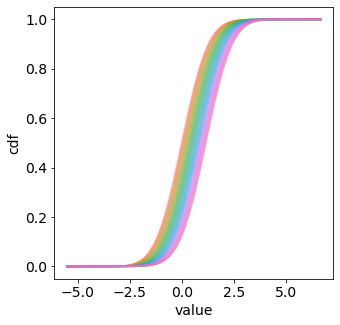

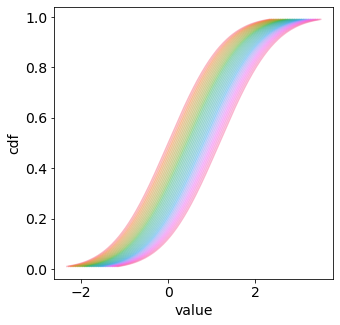

In [18]:
plot_cdf(predictions, samples)
plot_icdf(predictions, samples)
plot_cdf(predictions)
plot_icdf(predictions)

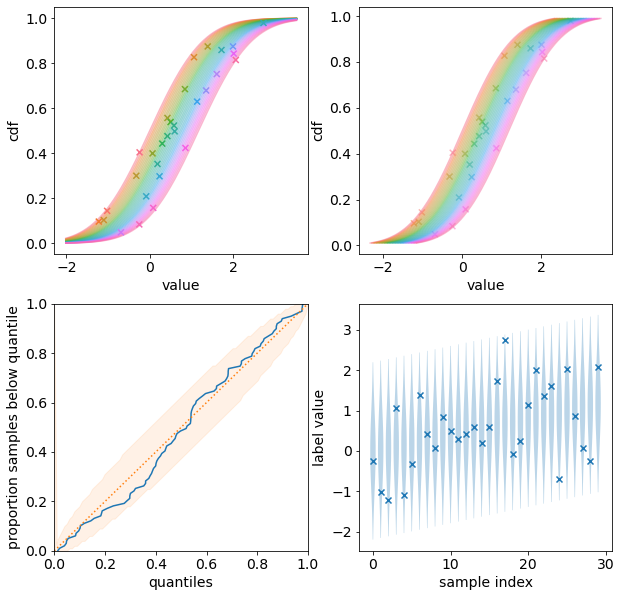

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plot_cdf(predictions, samples, ax=axs[0][0])
plot_icdf(predictions, samples, ax=axs[0][1])
plot_reliability_diagram(predictions, samples, ax=axs[1][0])
plot_density(predictions, samples, max_count=30, ax=axs[1][1])
plt.show()